In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [157]:
source('../0_parameters.sh')

source('../PRS_PheWAS.functions.R')

source('MR_functions.R')


In [141]:
devtools::load_all('/oak/stanford/groups/mrivas/users/ytanigaw/repos/yk-tanigawa/cud4')


Loading cud4



In [6]:
HGI_cc <- 'B2'
HGI_sx <- 'eur_leave_ukbb_23andme'
GBE_ID <- 'INI10030610' #Blood clot or DVT diagnosed by doctor
p_thr <- 5e-8

In [168]:
out_prefix <- file.path(sprintf('%s.%s.%s', HGI_cc, HGI_sx, GBE_ID))


In [82]:
window = 1.5e6
genes = data.frame(
    SYMBOL = c('ABO', 'FUT2'),
    CHROM = c('9', '19'),
    POS_s = c(136125788, 49199228),
    POS_e = c(136150617, 49209207),
    stringsAsFactors=F
)


In [3]:
ukb_phe_info %>% fread() -> ukb_phe_info_df

In [4]:
setNames(
    ukb_phe_info_df$GBE_short_name,
    ukb_phe_info_df$GBE_ID
) -> ukb_phe_info_dict

In [17]:
# ukb_array_combined_annot_f %>%
# fread(select=c('ID', 'ld_indep')) -> annot_df


In [15]:
ukb_array_combined_annot_f %>%
fread(colClasses = c('#CHROM'='character')) %>%
rename('CHROM'='#CHROM') -> annot_df


In [8]:
file.path(data_d, 'plink_format_UKB_cal', UKB_cal_f) %>%
str_replace('@@HGI_case_control@@', HGI_cc) %>%
str_replace('@@HGI_suffix@@', HGI_sx) %>%
read_sumstats() -> hgi_df


In [9]:
file.path(data_scratch_d, 'UKB_MR', 'sumstats', sprintf('%s.p1e-5.tsv.gz', GBE_ID)) %>%
read_sumstats() %>%
filter(log10P < log10(p_thr)) -> ukb_df


In [10]:
if(! 'BETA' %in% names(ukb_df)){
    ukb_df %>%
    mutate(BETA = log(OR)) %>%
    rename('SE'='LOG(OR)_SE') -> ukb_df
}


In [24]:
ukb_df %>%
filter(
    ID %in% (annot_df %>% filter(ld_indep == T) %>% pull(ID))
) %>%
join_ukb_hgi(hgi_df) %>%
left_join(
    annot_df,
) -> df


Joining, by = c("CHROM", "POS", "ID", "REF", "ALT")



In [25]:
df %>% dim()

[1] 1419   47

In [27]:
df %>% colnames()

[1] "CHROM"                 "POS"                   "ID"                   
 [4] "REF"                   "ALT"                   "A1"                   
 [7] "TEST"                  "OBS_CT_ukb"            "BETA_ukb"             
[10] "SE_ukb"                "T_STAT"                "P_ukb"                
[13] "P_base_ukb"            "P_exp_ukb"             "ERRCODE"              
[16] "log10P_ukb"            "OBS_CT_hgi"            "BETA_hgi"             
[19] "SE_hgi"                "P_hgi"                 "P_base_hgi"           
[22] "P_exp_hgi"             "log10P_hgi"            "ratio"                
[25] "FILTER"                "POS_total"             "Allele"               
[28] "Csq"                   "Consequence"           "SYMBOL"               
[31] "Gene"                  "ld_indep"              "geno_data_source"     
[34] "array"                 "CNV_POS_s"             "CNV_POS_e"            
[37] "UKB_white_british_MAF" "hwe_p"                 "mgi_notes"            
[40] "f_miss"                "f_miss_UKBB"           "f_miss_UKBL"          
[43] "LoF"                   "LoF_filter"            "LoF_flags"            
[46] "LoF_info"              "HGVSp"

In [40]:
df %>% filter(SYMBOL %in% c('ABO', 'FUT2')) %>%
select(CHROM, POS, ID, SYMBOL, BETA_ukb, BETA_hgi, P_ukb, P_hgi)


CHROM,POS,ID,SYMBOL,BETA_ukb,BETA_hgi,P_ukb,P_hgi
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
9,136131576,rs55727303,ABO,0.0689796,0.132210,1.56313e-13,0.1082
9,136131592,rs7853989,ABO,0.0646303,0.045540,4.87713e-45,0.1769
9,136136773,rs8176696,ABO,0.0849361,-0.051900,1.71975e-23,0.4883
9,136137140,rs2073828,ABO,0.1510500,-0.078941,4.82745e-700,0.001858
9,136137547,rs55876802,ABO,0.0881303,0.065243,6.49014e-25,0.3332
19,49204021,rs57940795,FUT2,0.0775727,0.061202,8.00068e-101,0.03935
19,49206674,rs601338,FUT2,-0.1229500,-0.057266,6.79589e-522,0.007864
19,49206726,rs1800027,FUT2,0.0526503,0.019836,1.40341e-25,0.6209


In [86]:
ABO_c  <- genes %>% filter(SYMBOL == 'ABO') %>% pull(CHROM)
ABO_s  <- genes %>% filter(SYMBOL == 'ABO') %>% pull(POS_s)
ABO_e  <- genes %>% filter(SYMBOL == 'ABO') %>% pull(POS_e)
FUT2_c <- genes %>% filter(SYMBOL == 'FUT2') %>% pull(CHROM)
FUT2_s <- genes %>% filter(SYMBOL == 'FUT2') %>% pull(POS_s)
FUT2_e <- genes %>% filter(SYMBOL == 'FUT2') %>% pull(POS_e)


In [125]:
df %>% mutate(
    is_ABO = (
        (CHROM == ABO_c  & (ABO_s  - window < POS) & (POS < ABO_e  + window))
    ),
    is_FUT2 = (
        (CHROM == FUT2_c & (FUT2_s - window < POS) & (POS < FUT2_e + window ))
    ),
    locus = if_else(is_ABO, 'ABO', if_else(is_FUT2, 'FUT2', 'others')),
    plot_color = locus
) -> df


In [126]:
df %>% count(locus)

locus,n
<chr>,<int>
ABO,68
FUT2,38
others,1313


In [127]:
df %>% filter(! is_ABO, ! is_FUT2) -> df_remove_ABO_FUT2


In [128]:
df %>% dim() %>% print()
df_remove_ABO_FUT2 %>% dim() %>% print()

[1] 1419   52
[1] 1313   52


In [129]:
lmfit_full            <- lm(BETA_hgi ~ 0 + BETA_ukb, df, weights = (df$SE_hgi ** (-2)))
lmfit_remove_ABO_FUT2 <- lm(BETA_hgi ~ 0 + BETA_ukb, df_remove_ABO_FUT2, weights = (df_remove_ABO_FUT2$SE_hgi ** (-2)))


In [130]:
summary(lmfit_full)


Call:
lm(formula = BETA_hgi ~ 0 + BETA_ukb, data = df, weights = (df$SE_hgi^(-2)))

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-3.8545 -0.8225 -0.0463  0.7111  3.2020 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)    
BETA_ukb  0.12467    0.02501   4.985 6.96e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.124 on 1418 degrees of freedom
Multiple R-squared:  0.01722,	Adjusted R-squared:  0.01653 
F-statistic: 24.85 on 1 and 1418 DF,  p-value: 6.957e-07


In [131]:
summary(lmfit_remove_ABO_FUT2)


Call:
lm(formula = BETA_hgi ~ 0 + BETA_ukb, data = df_remove_ABO_FUT2, 
    weights = (df_remove_ABO_FUT2$SE_hgi^(-2)))

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-3.6328 -0.8008 -0.0595  0.7131  3.2271 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)    
BETA_ukb  0.16624    0.02774   5.994 2.65e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.113 on 1312 degrees of freedom
Multiple R-squared:  0.02665,	Adjusted R-squared:  0.02591 
F-statistic: 35.92 on 1 and 1312 DF,  p-value: 2.649e-09


In [158]:
plot_beta_vs_beta_color <- function(df, lmfit){
    df %>% ggplot(aes(x = BETA_ukb, y = BETA_hgi, color=plot_color)) +
    geom_abline(
        slope = (lmfit)$coefficients[['BETA_ukb']],
        color='#FF4B00', alpha=.5
    ) +
    geom_errorbar( aes(ymin = BETA_hgi-SE_hgi,  ymax = BETA_hgi+SE_hgi),  alpha=.2) +
    geom_errorbarh(aes(xmin = BETA_ukb-SE_ukb,  xmax = BETA_ukb+SE_ukb),  alpha=.2) +
    geom_point(alpha=.5) +
    theme_bw(base_size=16)
}


In [164]:
df %>% plot_beta_vs_beta_color(lmfit_full) +
labs(
    title = sprintf(
        'MR (%s)\nIVW estimate: %.2e, p = %.2e',
        HGI_sx,
        (lmfit_full)$coefficients[['BETA_ukb']],
        fit_to_df(lmfit_full) %>% pull(P)
    ),
    y = sprintf('BETA[SE] HGI (%s)', HGI_cc),
    x = sprintf('BETA[SE] UKB (%s)\n%s', GBE_ID, ukb_phe_info_dict[[GBE_ID]])
)  +
labs(color = 'locus') +
theme(legend.position = c(.2, .8)) +
scale_color_manual(values=setNames(
    c(cud4_colors()['blue'], cud4_colors()['yellow'], cud4_colors()['gray'] ),
    c('ABO', 'FUT2', 'others')
)) -> p_full


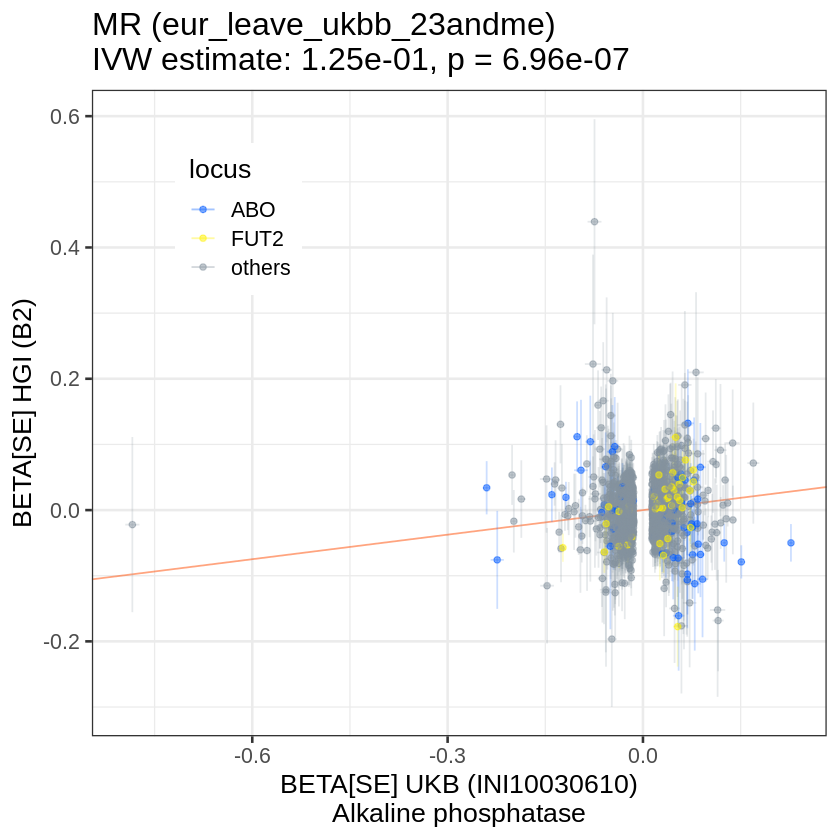

In [165]:
p_full


In [166]:
df_remove_ABO_FUT2 %>% plot_beta_vs_beta(lmfit_remove_ABO_FUT2) +
labs(
    title = sprintf(
        'MR (without ABO/FUT2, %s)\nIVW estimate: %.2e, p = %.2e',
        HGI_sx,
        (lmfit_remove_ABO_FUT2)$coefficients[['BETA_ukb']],
        fit_to_df(lmfit_remove_ABO_FUT2) %>% pull(P)
    ),
    y = sprintf('BETA[SE] HGI (%s)', HGI_cc),
    x = sprintf('BETA[SE] UKB (%s)\n%s', GBE_ID, ukb_phe_info_dict[[GBE_ID]])
) -> p_remove_ABO_FUT2


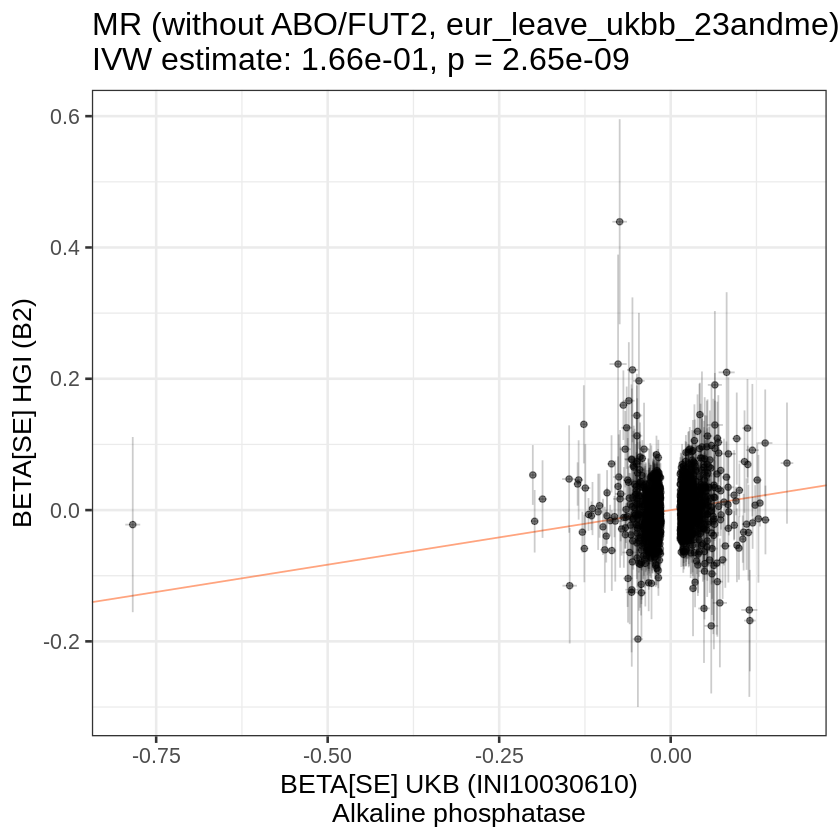

In [167]:
p_remove_ABO_FUT2

In [172]:
g <- gridExtra::arrangeGrob(
    p_full, p_remove_ABO_FUT2, ncol=2
)

ggsave(sprintf('%s.ABO_FUT2.png', out_prefix), g, height=8, width=16)
ggsave(sprintf('%s.ABO_FUT2.pdf', out_prefix), g, height=8, width=16)


In [ ]:
ggsave(file=out_f, g, width=16, height=8)

In [ ]:
    gridExtra::arrangeGrob(
        dff %>% p_pval_vs_pval(), 
        dff %>% p_beta_vs_beta(),
        ncol=2,
        top=grid::textGrob(sprintf(
            "Comparison of PRS-PheWAS associations (%s, %s, clump p1: %s)",
            HGI_cc, HGI_sx, str_replace(as.character(clumpp), '0', '')
        ),gp=grid::gpar(fontsize=20))
    ) -> g


    ggsave(file=str_replace(out_f, '.png$', '.pdf'), g, width=16, height=8)


In [54]:
bind_rows(
    lm(BETA_hgi ~ 0 + BETA_ukb, df, weights = (df$SE_hgi ** (-2))) %>% fit_to_df() %>%
    mutate(method = 'IVW')
) %>%
mutate(
    HGI_case_control = HGI_cc,
    HGI_suffix = HGI_sx,
    trait = GBE_ID,
    trait_name = ukb_phe_info_dict[[GBE_ID]]
) %>%
select(HGI_case_control, HGI_suffix, trait, trait_name, method, variable, estimate, SE, z_or_t_value, P)


HGI_case_control,HGI_suffix,trait,trait_name,method,variable,estimate,SE,z_or_t_value,P
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
C2,eur_leave_ukbb_23andme,BIN_FC11006152,Blood clot or DVT diagnosed by doctor,IVW,BETA_ukb,0.07440127,0.02350923,3.164768,0.003467648


In [16]:
plot_beta_vs_beta <- function(df, lmfit){
    df %>% ggplot(aes(x = BETA_ukb, y = BETA_hgi)) + 
    geom_abline(
        slope = (lmfit)$coefficients[['BETA_ukb']],
        color='red', alpha=.5
    ) + 
    geom_point(alpha=.1) +
    theme_bw()
}


In [10]:
lmfit <- lm(BETA_hgi ~ 0 + BETA_ukb, df, weights = (df$SE_hgi ** (-2)))

In [27]:
fit_to_df(lmfit)

variable,estimate,SE,z_or_t_value,P
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BETA_ukb,0.0629811,0.02339049,2.692594,0.01224045


In [11]:
summary(lmfit) 


Call:
lm(formula = BETA_hgi ~ 0 + BETA_ukb, data = df, weights = (df$SE_hgi^(-2)))

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-4.4391 -1.2815 -0.5375  0.1114  1.8607 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)   
BETA_ukb  0.07440    0.02351   3.165  0.00347 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.466 on 31 degrees of freedom
Multiple R-squared:  0.2442,	Adjusted R-squared:  0.2198 
F-statistic: 10.02 on 1 and 31 DF,  p-value: 0.003468


In [12]:
compute_IVW_estimate(df)

[1] 0.06533104

In [27]:
sprintf('%.2e', (lmfit)$coefficients[['BETA_ukb']])

[1] "7.44e-02"

In [ ]:
df %>% ggplot(aes(x = BETA_ukb, y = BETA_hgi)) + 
geom_abline(
    slope = (lmfit)$coefficients[['BETA_ukb']],
    color='red', alpha=.5
) + 
geom_errorbar( aes(ymin = BETA_hgi-SE_hgi,  ymax = BETA_hgi+SE_hgi),  alpha=.2) +
geom_errorbarh(aes(xmin = BETA_ukb-SE_ukb,  xmax = BETA_ukb+SE_ukb),  alpha=.2) +
geom_point(alpha=.5) +
theme_bw(base_size=16) + 
labs(
    title = sprintf(
        'MR (%s)\nIVW estimate: %.2e, p = %.2e',
        HGI_sx,
        (lmfit)$coefficients[['BETA_ukb']],
        fit_to_df(lmfit) %>% pull(P)
    ),
    y = sprintf('BETA[SE] HGI (%s)', HGI_cc),
    x = sprintf('BETA[SE] UKB (%s)', GBE_ID)
) -> p


In [52]:
df %>% ggplot(aes(x = BETA_ukb, y = BETA_hgi)) + 
geom_abline(
    slope = (lmfit)$coefficients[['BETA_ukb']],
    color='red', alpha=.5
) + 
geom_errorbar( aes(ymin = BETA_hgi-SE_hgi,  ymax = BETA_hgi+SE_hgi),  alpha=.2) +
geom_errorbarh(aes(xmin = BETA_ukb-SE_ukb,  xmax = BETA_ukb+SE_ukb),  alpha=.2) +
geom_point(alpha=.5) +
theme_bw(base_size=16) + 
labs(
    title = sprintf(
        'MR (%s)\nIVW estimate: %.2e, p = %.2e',
        HGI_sx,
        (lmfit)$coefficients[['BETA_ukb']],
        fit_to_df(lmfit) %>% pull(P)
    ),
    y = sprintf('BETA[SE] HGI (%s)', HGI_cc),
    x = sprintf('BETA[SE] UKB (%s)\n%s', GBE_ID, ukb_phe_info_dict[[GBE_ID]])
) -> p


In [43]:
ggsave(sprintf('%s.%s.%s.png', HGI_cc, HGI_sx, GBE_ID), p, height=8, width=8)
ggsave(sprintf('%s.%s.%s.pdf', HGI_cc, HGI_sx, GBE_ID), p, height=8, width=8)